In [1]:
import raman_rabi
from raman_rabi import rr_model
from raman_rabi import rr_io
from raman_rabi import RRDataContainer
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
#import warnings
#warnings.filterwarnings("error")

0.7239967162417723
0.7324032403240324


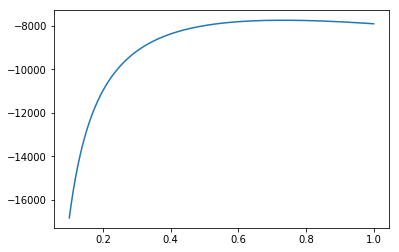

In [3]:
#binned_MAP_params are found by maximizing binned data likelihood over each param assuming
#the params from the paper for all other params
binned_MAP_params = np.array([6.22622623e+00, 1.68718719e+01, 1.52076134e-02, 5.09509510e+00, -3.54854855e-01, 1.21121121e-01])

#import mN=+1 data
data_length = 20
testfilepath = rr_io.get_example_data_file_path("21.07.56_Pulse Experiment_E1 Raman Pol p0 Rabi Rep Readout - -800 MHz, ND0.7 Vel1, Presel 6 (APD2, Win 3)_ID10708_image.txt")
mN1_data = RRDataContainer(testfilepath)

#skew_value_params calculated based on average height of each run
greatest = np.max(np.average(mN1_data.get_df().values, axis=1))
skew_value_params = np.average(mN1_data.get_df().values, axis=1)/greatest
print(skew_value_params[0])

theta = np.concatenate( (binned_MAP_params, skew_value_params), axis=0)
#print(theta)
param_length = len(theta)

variation_length = 10000
variation_range = np.linspace(0.1, 1, variation_length)
MAP_values = np.zeros(param_length)

param_index = 6
temp_likelihood = np.zeros(variation_length)
for jjj in range(variation_length):
    theta_temp = np.copy(theta)
    theta_temp[param_index] = variation_range[jjj]
    theta_temp[0] = 15.634563456345633
    theta_temp[1] = 17.27272727272727
    theta_temp[2] = 0.018601860186018726
    theta_temp[3] = 9.03990399039904
    theta_temp[4] = -0.281028102810281
    theta_temp[5] = 0.17461746174617462
    temp_likelihood[jjj] = rr_model.laserskew_unbinned_loglikelihood_mN1(theta_temp, mN1_data, 0, 40, True)
    
print(variation_range[np.argmax(temp_likelihood)])

plt.figure()
plt.plot(variation_range, temp_likelihood)

#print(binned_MAP_params)
#print(skew_value_params)
#print(theta)

#for iii in range(param_length):
#    temp_likelihood = np.zeros(variation_length)
#    for jjj in range(variation_length):
#        theta_temp = np.copy(theta) #make deep copy so that data not errased
#        theta_temp[iii] = variation_range[jjj]
#        temp_likelihood[jjj] = rr_model.laserskew_unbinned_loglikelihood_mN1(theta_temp, mN1_data, 0, 40, True)
#    MAP_values[iii] = variation_range[np.argmax(temp_likelihood)]

#print(MAP_values)

#print(theta)

# Proper Sequential Model?

# Using Initial Guesses from Sequentially Found Unbinned Guesses

Guess Parameters
[10.0139361, 25.5856052, 0.0177377962, 8.351489, -0.325686294, 0.132561796]
MCMC Parameters
[ 9.06016585e+00  2.63746751e+01  1.68131122e-02  8.39814674e+00
 -3.25166896e-01  1.32936637e-01]

Estimated Laserskew
[0.72399672 0.75163799 0.4608927  0.6089271  0.90601965 0.78624078
 0.54033579 0.53583129 0.85667485 0.92424241 0.72481573 0.75696151
 0.72788697 0.81040131 0.67915643 0.59193284 1.         0.83579032
 0.68837019 0.82739559]
MCMC Laserskew
[0.72851218 0.76803395 0.48302139 0.63623208 0.89357176 0.7971548
 0.57268108 0.56466604 0.85095267 0.91885105 0.74449227 0.78849105
 0.7393039  0.80789183 0.69238137 0.60081677 0.97114142 0.83688047
 0.68767503 0.83602462]



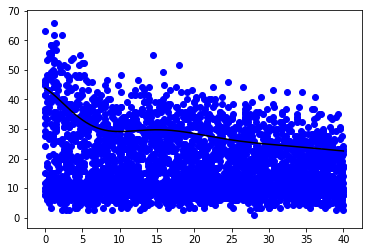

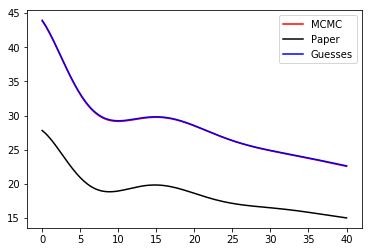

In [26]:
##Here we use our unbinned, newly minimized param values
#params = np.array([15.634563456345633, 17.27272727272727, 0.018601860186018726, 9.03990399039904, -0.281028102810281, 0.17461746174617462])

#these are the params that we get from running for the first 20000 steps
params = [1.00139361e+01, 2.55856052e+01, 1.77377962e-02, 8.35148900e+00, -3.25686294e-01, 1.32561796e-01]
theta = np.concatenate( (params, skew_value_params), axis=0)

# run MCMC on the test data and see if it's pretty close to the original theta
guesses = theta
numdim = len(guesses)
numwalkers = 200
numsteps = 20000
np.random.seed(0)
test_samples = rr_model.laserskew_Walkers(mN1_data, guesses,0, 40, True, dataN=10,scale_factor=100*100,nwalkers=numwalkers,nsteps=numsteps)
burn_in_time = 200
samples = test_samples.chain[:,burn_in_time:,:]
traces = samples.reshape(-1, numdim).T
parameter_samples = pd.DataFrame({'BG': traces[0],
				  'Ap': traces[1],
				  'Gammap': traces[2],
				  'Ah': traces[3],
				  'Omegah': traces[4],
				  'Gammadeph': traces[5] })
laserskew_samples = pd.DataFrame(traces[6:].T)
MAP = parameter_samples.quantile([0.50], axis=0)
laserskew_MAP = laserskew_samples.quantile([0.50],axis=0)

BG_MCMC = MAP['BG'].values[0]
Ap_MCMC = MAP['Ap'].values[0]
Gammap_MCMC = MAP['Gammap'].values[0]
Ah_MCMC = MAP['Ah'].values[0]
Omegah_MCMC = MAP['Omegah'].values[0]
Gammadeph_MCMC = MAP['Gammadeph'].values[0]

print('Guess Parameters')
print(params)
print('MCMC Parameters')
print(np.percentile(traces[0:6, :], 50, axis=1))
print()

print('Estimated Laserskew')
print(skew_value_params)
print('MCMC Laserskew')
print(np.percentile(traces[6:len(theta), :], 50, axis=1))
print()

time, mu = rr_model.ideal_model(161, 0, 40, BG_MCMC, Ap_MCMC, Gammap_MCMC, Ah_MCMC, Omegah_MCMC, Gammadeph_MCMC)

scale_factor = 100*100
N_value = 10

plt.figure()
#plt.scatter(time, np.sum(mN1_data.get_df().values, axis=0)*scale_factor/N_value/data_length)
for iii in range(data_length):
    plt.scatter(time, mN1_data.get_df().values[iii, :]*scale_factor/N_value, color='b')
plt.plot(time, mu, color='k')
plt.show()

##paper values
BG = 6.1
Ap =16.6881
Gammap = 1/63.8806
Ah = 5.01886
Omegah = -np.pi/8.77273
Gammadeph = 1/8.5871
time, paper_mu = rr_model.ideal_model(161, 0, 40, BG, Ap, Gammap, Ah, Omegah, Gammadeph)
##Sequentially estimated guesses
time, prior_mu = rr_model.ideal_model(161, 0, 40, params[0], params[1], params[2], params[3], params[4], params[5])
##Compare Results
plt.figure()
plt.plot(time, mu, color='r', label='MCMC')
plt.plot(time, paper_mu, color='k', label='Paper')
plt.plot(time, prior_mu, color='b', label='Guesses')
plt.legend()
plt.show()

[7.51605116e+00 2.77082120e+01 1.55733032e-02 8.46762066e+00
 3.24482044e-01 1.33983631e-01]

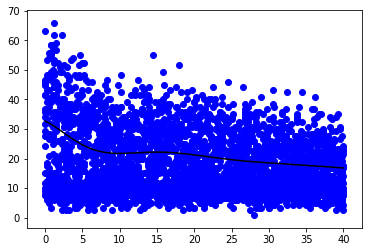

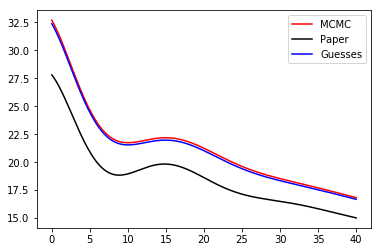

In [27]:
time, mu = rr_model.ideal_model(161, 0, 40, BG_MCMC, Ap_MCMC, Gammap_MCMC, Ah_MCMC, Omegah_MCMC, Gammadeph_MCMC)
mu = mu*np.mean(np.percentile(traces[6:len(theta), :], 50, axis=1)) #we multiply mu by the 50th percentile
#mean of laser skew

scale_factor = 100*100
N_value = 10

plt.figure()
#plt.scatter(time, np.sum(mN1_data.get_df().values, axis=0)*scale_factor/N_value/data_length)
for iii in range(data_length):
    plt.scatter(time, mN1_data.get_df().values[iii, :]*scale_factor/N_value, color='b')
plt.plot(time, mu, color='k')
plt.show()

##paper values
BG = 6.1
Ap =16.6881
Gammap = 1/63.8806
Ah = 5.01886
Omegah = -np.pi/8.77273
Gammadeph = 1/8.5871
time, paper_mu = rr_model.ideal_model(161, 0, 40, BG, Ap, Gammap, Ah, Omegah, Gammadeph)
##Sequentially estimated guesses
time, prior_mu = rr_model.ideal_model(161, 0, 40, params[0], params[1], params[2], params[3], params[4], params[5])
prior_mu = prior_mu*np.mean(skew_value_params)
##Compare Results
plt.figure()
plt.plot(time, mu, color='r', label='MCMC')
plt.plot(time, paper_mu, color='k', label='Paper')
plt.plot(time, prior_mu, color='b', label='Guesses')
plt.legend()
plt.show()

(3960000, 6)
19800
3960000
(200, 20000, 26)


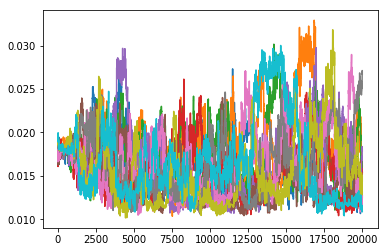

In [30]:
print(parameter_samples.shape)
steps = numsteps - burn_in_time
print(steps)
print(numwalkers*steps)
print(test_samples.chain.shape)

param1 = 2

for iii in range(10):
    plt.plot(test_samples.chain[iii, :, param1])

# Using Initial Guesses from Binned Data

Guess Parameters
[6.32483088, 28.1261249, 0.0141594611, 8.62033094, 0.31374016, 0.13372434]
MCMC Parameters
[7.51605116e+00 2.77082120e+01 1.55733032e-02 8.46762066e+00
 3.24482044e-01 1.33983631e-01]

Estimated Laserskew
[0.72399672 0.75163799 0.4608927  0.6089271  0.90601965 0.78624078
 0.54033579 0.53583129 0.85667485 0.92424241 0.72481573 0.75696151
 0.72788697 0.81040131 0.67915643 0.59193284 1.         0.83579032
 0.68837019 0.82739559]
MCMC Laserskew
[0.72956782 0.7688612  0.48348287 0.63656006 0.89449578 0.79776382
 0.57305102 0.56522728 0.85221146 0.91949259 0.74519037 0.78905225
 0.73962958 0.808247   0.6930248  0.60153293 0.97181944 0.83754263
 0.68824552 0.83643242]



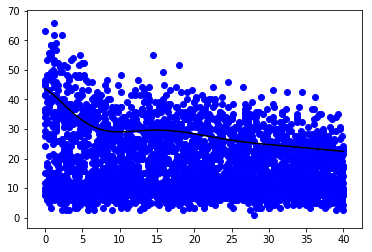

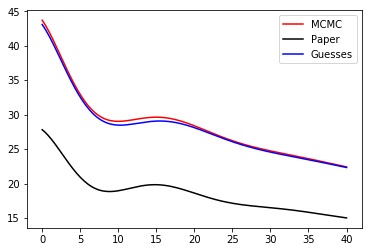

In [31]:
#binned estimates
#params = np.array([6.22622623e+00, 1.68718719e+01, 1.52076134e-02, 5.09509510e+00, -3.54854855e-01, 1.21121121e-01])
#these params are after first 20000 steps
params = [6.32483088e+00, 2.81261249e+01, 1.41594611e-02, 8.62033094e+00, 3.13740160e-01, 1.33724340e-01]
theta = np.concatenate( (params, skew_value_params), axis=0)

# run MCMC on the test data and see if it's pretty close to the original theta
guesses = theta
numdim = len(guesses)
numwalkers = 200
numsteps = 20000
np.random.seed(0)
test_samples = rr_model.laserskew_Walkers(mN1_data, guesses,0, 40, True, dataN=10,scale_factor=100*100,nwalkers=numwalkers,nsteps=numsteps)
burn_in_time = 200
samples = test_samples.chain[:,burn_in_time:,:]
traces = samples.reshape(-1, numdim).T
parameter_samples = pd.DataFrame({'BG': traces[0],
				  'Ap': traces[1],
				  'Gammap': traces[2],
				  'Ah': traces[3],
				  'Omegah': traces[4],
				  'Gammadeph': traces[5] })
laserskew_samples = pd.DataFrame(traces[6:].T)
MAP = parameter_samples.quantile([0.50], axis=0)
laserskew_MAP = laserskew_samples.quantile([0.50],axis=0)
BG_MCMC = MAP['BG'].values[0]
Ap_MCMC = MAP['Ap'].values[0]
Gammap_MCMC = MAP['Gammap'].values[0]
Ah_MCMC = MAP['Ah'].values[0]
Omegah_MCMC = MAP['Omegah'].values[0]
Gammadeph_MCMC = MAP['Gammadeph'].values[0]

print('Guess Parameters')
print(params)
print('MCMC Parameters')
print(np.percentile(traces[0:6, :], 50, axis=1))
print()

print('Estimated Laserskew')
print(skew_value_params)
print('MCMC Laserskew')
print(np.percentile(traces[6:len(theta), :], 50, axis=1))
print()

time, mu = rr_model.ideal_model(161, 0, 40, BG_MCMC, Ap_MCMC, Gammap_MCMC, Ah_MCMC, Omegah_MCMC, Gammadeph_MCMC)

scale_factor = 100*100
N_value = 10

plt.figure()
#plt.scatter(time, np.sum(mN1_data.get_df().values, axis=0)*scale_factor/N_value/data_length)
for iii in range(data_length):
    plt.scatter(time, mN1_data.get_df().values[iii, :]*scale_factor/N_value, color='b')
plt.plot(time, mu, color='k')
plt.show()

##paper values
BG = 6.1
Ap =16.6881
Gammap = 1/63.8806
Ah = 5.01886
Omegah = -np.pi/8.77273
Gammadeph = 1/8.5871
time, paper_mu = rr_model.ideal_model(161, 0, 40, BG, Ap, Gammap, Ah, Omegah, Gammadeph)
##Sequentially estimated guesses
time, prior_mu = rr_model.ideal_model(161, 0, 40, params[0], params[1], params[2], params[3], params[4], params[5])
##Compare Results
plt.figure()
plt.plot(time, mu, color='r', label='MCMC')
plt.plot(time, paper_mu, color='k', label='Paper')
plt.plot(time, prior_mu, color='b', label='Guesses')
plt.legend()
plt.show()

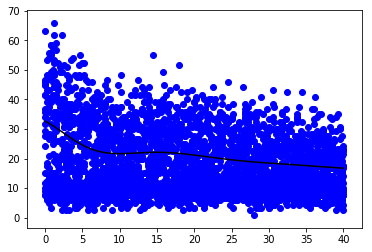

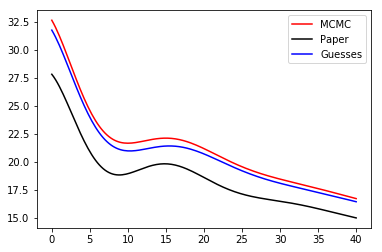

In [34]:
time, mu = rr_model.ideal_model(161, 0, 40, BG_MCMC, Ap_MCMC, Gammap_MCMC, Ah_MCMC, Omegah_MCMC, Gammadeph_MCMC)
mu = mu*np.mean(np.percentile(traces[6:len(theta), :], 50, axis=1)) #we multiply mu by the 50th percentile
#mean of laser skew

scale_factor = 100*100
N_value = 10

plt.figure()
#plt.scatter(time, np.sum(mN1_data.get_df().values, axis=0)*scale_factor/N_value/data_length)
for iii in range(data_length):
    plt.scatter(time, mN1_data.get_df().values[iii, :]*scale_factor/N_value, color='b')
plt.plot(time, mu, color='k')
plt.show()

##paper values
BG = 6.1
Ap =16.6881
Gammap = 1/63.8806
Ah = 5.01886
Omegah = -np.pi/8.77273
Gammadeph = 1/8.5871
time, paper_mu = rr_model.ideal_model(161, 0, 40, BG, Ap, Gammap, Ah, Omegah, Gammadeph)
##Sequentially estimated guesses
time, prior_mu = rr_model.ideal_model(161, 0, 40, params[0], params[1], params[2], params[3], params[4], params[5])
prior_mu = prior_mu*np.mean(skew_value_params)
##Compare Results
plt.figure()
plt.plot(time, mu, color='r', label='MCMC')
plt.plot(time, paper_mu, color='k', label='Paper')
plt.plot(time, prior_mu, color='b', label='Guesses')
plt.legend()
plt.show()

(3960000, 6)
19800
3960000
(200, 20000, 26)


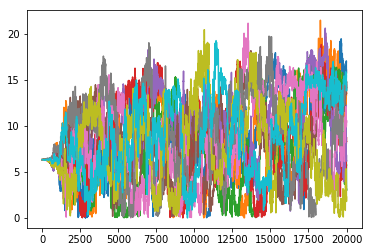

In [35]:
print(parameter_samples.shape)
steps = numsteps - burn_in_time
print(steps)
print(numwalkers*steps)
print(test_samples.chain.shape)

param1 = 0

for iii in range(10):
    plt.plot(test_samples.chain[iii, :, param1])